# Introduction
The following notebook implements a machine learning approach to solve the water data minning challenge of Tanzania. https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/

# Setup the environment

Importing all the libraries and functions that are going to be used in the analysis.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import warnings

from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, MinMaxScaler, scale
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate

from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

from functools import reduce

warnings.simplefilter(action='ignore')

# General Functions

## Loading the data - Function

Creating a function to load the data for the analysis.

In [2]:
def loading_data (path):
    df = pd.read_csv(path)
    return df

## Subsetting important variables - Function

Creating a function to create a numerical label for the categorical variables.

In [3]:
def filter_important (df, important_variables):
    
    return df[important_variables]

## Label Encoder - Function

Creating a function to create a numerical label for the categorical variables.

In [4]:
def label_encoder (df):
    
    # Creating the label encoder object
    le =  LabelEncoder()
    
    # Iterating over the "object" variables to transform the categories into numbers 
    for col in df.columns.values:
        if df[col].dtypes == "object":
            df[col] = le.fit_transform(df[col].astype(str))
    return df

## Scaler - Function

Creating a function that scale all the numerical variables.

In [5]:
def scaler_function (df):
    
    # Initializing the scaler function
    min_max = MinMaxScaler()
    
    # Dropping the objective variable as it won't be scaled
    columns_to_scale = df.columns[df.columns != 'status_group']
    
    # Transforming and replacing the variables with its scaled version
    df[columns_to_scale] = min_max.fit_transform(df[columns_to_scale])
    
    return df

## Standardization - Function

Creating a function that standardize all the numerical variables.

In [6]:
def standardization_function (df):
    
    # Dropping the objective variable as it won't be scaled
    columns_to_standardize = df.columns[df.columns != 'status_group']
    
    # Transforming and replacing the variables with its scaled version
    df[columns_to_standardize] = scale(df[columns_to_standardize])
    
    return df

# Model No.1 - Random Forest

## Creating the baseline pipeline model No.1 - Function

Creating the training model which will be used in the pipeline to evaluate the performance of the transformations and feature engineering functions. It includes a cross validation (CV) function in order to avoid rejecting a function with just one score and presents the standard deviation too to evaluate the impact on the model stability. 

Due to the computational power required to run a Random Forest model, the one used in the pipeline will be very simple as its objective is only to evaluate if the transformation/feature engingeering function improves or not the performance. The hyperparameter tunning will be left for the production model.

In [7]:
def score_model_RF(data):
        
    # Creating the independent and dependent variables dataframes.
    X = data.loc[:, data.columns != 'status_group']
    y = data.loc[:, 'status_group']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.30, 
                                                        random_state = 4852347)
    
    # Creating the classifier
    clf = RandomForestClassifier(random_state = 4852347) 
    # Cross Validation of the Scores to stabilize variance and don't eliminate functions with only 
    # one run of the model
    scores = cross_val_score(clf, 
                             X_train, y_train, 
                             scoring='accuracy', cv=10)
    
    print('Mean training score RF with CV: {:.4f}, standard deviation: {:.4f} '.format(np.mean(scores), np.std(scores)), 
              end='')
    
    clf.fit(X_train, y_train)
    print('\nRF Model score in holdout: {:.4f}'.format(clf.score(X_test, y_test)))

# Model No.2 - XGBoost

## Creating the baseline pipeline model No.2 - Function

Creating the training model which will be used in the pipeline to evaluate the performance of the transformations and feature engineering functions. It includes a cross validation (CV) function in order to avoid rejecting a function with just one score and presents the standard deviation too to evaluate the impact on the model stability. 

As the computational power required to run a XGBoost model is really high and the performance was lower than the Random Forest, this model was just used for comparison and not in the pipeline. Nevertheless, it will be used in production for the model stacking.

In [8]:
def score_model_XGB(data):
    
    # Creating the independent and dependent variables dataframes.
    X = data.loc[:, data.columns != 'status_group']
    y = data.loc[:, 'status_group']

    # Creating the classifier
    xgboost = xgb.XGBClassifier(random_state = 4852347) 
 
    # Cross Validation of the Scores to stabilize variance and don't eliminate functions with only 
    # one run of the model
    scores = cross_val_score(xgboost, 
                             X_train, y_train, 
                             scoring='accuracy', cv=10)
    
    print('Mean training score XGB with CV: {:.4f}, standard deviation: {:.4f} '.format(np.mean(scores), np.std(scores)), 
              end='')
    
    clf.fit(X_train, y_train)
    print('\nXGB Model score in holdout: {:.4f}'.format(clf.score(X_test, y_test)))

# Running everything

## Loading Data

In [9]:
train_values_url = "http://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv"
train_labels_url = "http://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv"
test_values_url = "http://s3.amazonaws.com/drivendata/data/7/public/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv"

# Import train_values (X_train)
train_values = loading_data(train_values_url)
# Import train_labels (y_train)
train_labels = loading_data(train_labels_url)
# Import test_values (X_test)
test_values = loading_data(test_values_url)

## Train Values

First we want to see the table structure of the the train values.

In [10]:
train_values.head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


Secondly, we want to analyze the descriptive summary of all the variables.

In [11]:
train_values.describe(include = "all")

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59400.000000,59400.000000,59400,55765,59400.000000,55745,59400.000000,5.940000e+04,59400,59400.000000,...,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,NaN,NaN,356,1897,NaN,2145,NaN,NaN,37400,NaN,...,7,8,6,5,5,10,7,3,7,6
top,NaN,NaN,2011-03-15,Government Of Tanzania,NaN,DWE,NaN,NaN,none,NaN,...,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,NaN,NaN,572,9084,NaN,17402,NaN,NaN,3563,NaN,...,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625
mean,37115.131768,317.650385,NaN,NaN,668.297239,NaN,34.077427,-5.706033e+00,NaN,0.474141,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,21453.128371,2997.574558,NaN,NaN,693.116350,NaN,6.567432,2.946019e+00,NaN,12.236230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,NaN,NaN,-90.000000,NaN,0.000000,-1.164944e+01,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,18519.750000,0.000000,NaN,NaN,0.000000,NaN,33.090347,-8.540621e+00,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,37061.500000,0.000000,NaN,NaN,369.000000,NaN,34.908743,-5.021597e+00,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,55656.500000,20.000000,NaN,NaN,1319.250000,NaN,37.178387,-3.326156e+00,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As it can be seen, the complexity of the dataset is pretty high. Thus, in order to optimize the analysis, the EDA will be complemented by a simple Random Forest model developed in Dataiku to evaluate the performance of each variable in the prediction of the status_group variable. The objective is to reduce the dimensionality of the problem to focus on the preparation and feature engineering functions in the variables that are significant for the prediction.

Additionally, in this EDA the redundant variables were determined so they are not going to be included in the list of final variables for the model.  

### Merging with objective variable
Before entering the dataset to the model, we have to merge the train_set with the objective variable to then be label encoded.

In [12]:
train_merged = pd.merge(train_labels.copy(),train_values.copy(),on = "id")
train_merged.head(1)

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


# 1. Baseline Score
Showing the baseline score with all the variables and no transformations (just label encoder). This model will be the reference for all the applied transformations.

In [13]:
score_model_RF(label_encoder(train_merged.copy()).drop("id",axis = 1))

Mean training score RF with CV: 0.7948, standard deviation: 0.0047 
RF Model score in holdout: 0.7962


# 2. Feature Selection
Subsetting the dataset based on the importance and duplicity of the variables (the EDA of this step was done in Dataiku).

In [14]:
# Defining the important variables, by order of importance, to subset the dataframe.

important_variables = ['id','quantity', 'longitude', 'latitude', 'construction_year',
                       'gps_height', 'extraction_type', 'waterpoint_type', 'population', 
                       'management', 'source', 'payment', 'basin', 'funder', 'permit',
                       'date_recorded', 'scheme_name', 'quality_group', 'source_class',
                       'public_meeting', 'water_quality', 'amount_tsh'
                       , 'management_group'
                       ,'installer'
                       ,'lga'
                       ,'ward'
                       ,'scheme_management'
                      ]

# Eliminated variables
# 'num_private': almost 99% of missing values
# 'wpt_name': name of the waterpoint, similar to ID.
# 'subvillage': location information (will be covered by lga and ward which has more complete data)
# 'region': location information (will be covered by lga and ward which has more complete data)
# 'region_code': location information (will be covered by lga and ward which has more complete data)
# 'district_code': location information (will be covered by lga and ward which has more complete data)
# 'recorded_by': just one unique value "GeoData Consultants Ltd"
# 'extraction_type_group': duplicated with extraction_type
# 'extraction_type_class': duplicated with extraction_type
# 'payment_type': duplicated with payment
# 'quantity_group': duplicated with quantity
# 'waterpoint_type_group':  duplicated with waterpoint_type

In [15]:
train_important_variables = filter_important(train_values.copy(),important_variables)
train_important_variables = pd.merge(train_labels.copy(),train_important_variables.copy(),on = "id").drop("id",axis = 1)

test_important_variables = filter_important(test_values.copy(),important_variables)

#train_important_variables.dtypes


In [16]:
score_model_RF(label_encoder(train_important_variables.copy()))

Mean training score RF with CV: 0.7927, standard deviation: 0.0044 
RF Model score in holdout: 0.7906


The performance of the model decreased by some decimals but 12 features were eliminated. Thus, we will continue with this transformed dataset (same procedure applied to test_set).

# 3. Feature Engineering
Creating new variables based on its relationships with other variables.

## 3.1 geo_location
As the variables lga (local government authority) and ward (administrative region - lowest level of qualitative granularity) have information about qualitative location and present a high level of consistency throughout the dataset, they will be grouped.

In [17]:
train_important_variables["geo_location"] = train_important_variables["lga"].map(str) + ":" + train_important_variables["ward"].map(str)
train_important_variables = train_important_variables.drop(["lga","ward"],axis = 1)

test_important_variables["geo_location"] = test_important_variables["lga"].map(str) + ":" + test_important_variables["ward"].map(str)
test_important_variables = test_important_variables.drop(["lga","ward"],axis = 1)


In [18]:
score_model_RF(label_encoder(train_important_variables.copy()))

Mean training score RF with CV: 0.7934, standard deviation: 0.0047 
RF Model score in holdout: 0.7929


The performance of the model increased by some decimals but the standard deviation too. However, we reduced the dimensionality of the problem, thus the feature will be mantained.

## 3.2 Installer performance (perInterval)

In its original state the installer variable does not gives to much information to the model as it has too many distinct values, nevertheless, during the EDA we discovered that the majority of the dwells were installed by a relatively small group and they have a prestige of their dwells working good or bad. Thus, we will create a variable that will rank them between 0 and 10 according to its historic performance, as if they were likely to do it well, they are likely to do it well again.

In [19]:
df_U = train_important_variables.copy()

df_sub = df_U[['installer','status_group']]

df_sub.installer = df_sub.installer.fillna('unknown')
df_sub.installer = df_sub.installer.apply(lambda x: 'unknown' if x == '0' else x)

df_sub = df_sub.set_index('installer',inplace=False)
df_sub.status_group = df_sub['status_group'].astype('category')
status_cat = pd.get_dummies(df_sub.status_group)
status_count = status_cat.groupby(level=0).sum()
status_count.columns = ['f','fr','nf']
status_count['total'] = status_count.f + status_count.fr + status_count.nf
status_count['performance'] = status_count.f / status_count.total

In [20]:
df_exp = train_important_variables.copy()

df_exp.installer = df_exp.installer.fillna('unknown')

df_exp.installer = df_exp.installer.apply(lambda x: 'unknown' if x == '0' else x)

def cut2cat(data,tagcol,thebin):
    Cat = pd.cut(data[tagcol],bins=thebin).to_frame().astype("object")
    new_column_name = tagcol[0:3] + 'Interval'
    Cat.columns = [new_column_name]
    df = pd.concat([data,Cat],axis = 1)
    return df

perf = list(range(0,10,1))
perf = [x/10 for x in perf]
perf[0] = -0.1
perf[-1] = 1.1

installer_performance = cut2cat(status_count,'performance',perf)

df_exp = df_exp.join(installer_performance.perInterval,how='left',on='installer')

In [21]:
score_model_RF(label_encoder(df_exp.copy().drop("installer",axis=1)))

Mean training score RF with CV: 0.7977, standard deviation: 0.0036 
RF Model score in holdout: 0.7976


The model performance increased significantly and the standard deviation decreased too, thus it will be applied to the train and test set.

For the test set, there may be new installers that were not taken into consideration when the ranking was done for the train set, thus, these new installers will be classified as unknown as we do not have information about how they did in the past.

In [22]:
test_important_variables.installer = test_important_variables.installer.fillna('unknown')

test_important_variables.installer = test_important_variables.installer.apply(lambda x: 'unknown' if x == '0' else x)

list_installers = np.unique(list(train_important_variables.installer))
test_important_variables.installer = test_important_variables.installer.apply(lambda x: 'unknown' if x not in list_installers else x)

test_important_variables = test_important_variables.join(installer_performance.perInterval,how='left',on='installer')
test_important_variables = test_important_variables.drop("installer",axis=1)

In [23]:
train_important_variables = df_exp.copy().drop("installer",axis=1)

## 3.3 scheme_management and scheme_name performance
The scheme_name variable has a lot of missing values, however, in combination with the scheme management variable it may have valuable information for the prediction, thus, a new variable will be created from these two.

In [24]:
train_important_variables["scheme"] = train_important_variables["scheme_management"].map(str) + ":" + train_important_variables["scheme_name"].map(str)
train_important_variables = train_important_variables.drop(["scheme_management","scheme_name"],axis = 1)

In [25]:
score_model_RF(label_encoder(train_important_variables.copy()))

Mean training score RF with CV: 0.7980, standard deviation: 0.0048 
RF Model score in holdout: 0.7977


The score improved but the variance too, thus, further working is needed on the variable. The approach will be to do something similar to what was done with the variable installer, ranking the new variable according to its historical performance.

In [26]:
df_U = train_important_variables.copy()

df_sub = df_U[['scheme','status_group']]

df_sub.scheme = df_sub.scheme.fillna('unknown')
df_sub.scheme = df_sub.scheme.apply(lambda x: 'unknown' if x == '0' else x)

df_sub = df_sub.set_index('scheme',inplace=False)
df_sub.status_group = df_sub['status_group'].astype('category')
status_cat = pd.get_dummies(df_sub.status_group)
status_count = status_cat.groupby(level=0).sum()
status_count.columns = ['f','fr','nf']
status_count['total'] = status_count.f + status_count.fr + status_count.nf
status_count['performance'] = status_count.f / status_count.total

In [27]:
df_exp = train_important_variables.copy()

perf = list(range(0,10,1))
perf = [x/10 for x in perf]
perf[0] = -0.1
perf[-1] = 1.1

scheme_performance = cut2cat(status_count,'performance',perf).reset_index()
scheme_performance.rename(columns={'perInterval': 'per_scheme'}, inplace=True)
df_exp = pd.merge(df_exp,scheme_performance[["scheme","per_scheme"]], left_on = "scheme", right_on = "scheme",how = "left")


In [28]:
score_model_RF(label_encoder(df_exp.copy().drop("scheme",axis=1)))

Mean training score RF with CV: 0.8016, standard deviation: 0.0034 
RF Model score in holdout: 0.8014


The performance of the model increased significantly and the variance decreased. Thus, this transformation will be applied both to the training and test set. The same approach taken with the new installers will be taken here for the new schemes (assigning them as unknown).

In [29]:
test_important_variables["scheme"] = test_important_variables["scheme_management"].map(str) + ":" + test_important_variables["scheme_name"].map(str)
test_important_variables = test_important_variables.drop(["scheme_management","scheme_name"],axis = 1)

test_important_variables.scheme = test_important_variables.scheme.fillna('nan:nan')
test_important_variables.scheme = test_important_variables.scheme.apply(lambda x: 'nan:nan' if x == '0' else x)

list_scheme = np.unique(list(train_important_variables.scheme))
test_important_variables.scheme = test_important_variables.scheme.apply(lambda x: 'nan:nan' if x not in list_scheme else x)

test_important_variables = pd.merge(test_important_variables,scheme_performance[["scheme","per_scheme"]], left_on = "scheme", right_on = "scheme",how = "left")
test_important_variables = test_important_variables.drop("scheme",axis=1)

In [30]:
train_important_variables = df_exp.copy().drop("scheme",axis=1)

# 4. Exploratory Data Analysis and Data Preparation
In this stage we are going to go deeper in the analysis of the data to evaluate its characteristics. If there is some interesting finding which could lead to a new feature, it will also be also implemented in this stage.

## 4.1 Missing values
Analyze if there are missing values in the dataset.

In [31]:
missing_categorical_train = []

for column in train_important_variables.columns:
    if train_important_variables[column].isna().sum() > 0:
        missing_categorical_train.append(column)
    print(column+" missing values:"+str(train_important_variables[column].isna().sum()))

status_group missing values:0
quantity missing values:0
longitude missing values:0
latitude missing values:0
construction_year missing values:0
gps_height missing values:0
extraction_type missing values:0
waterpoint_type missing values:0
population missing values:0
management missing values:0
source missing values:0
payment missing values:0
basin missing values:0
funder missing values:3635
permit missing values:3056
date_recorded missing values:0
quality_group missing values:0
source_class missing values:0
public_meeting missing values:3334
water_quality missing values:0
amount_tsh missing values:0
management_group missing values:0
geo_location missing values:0
perInterval missing values:0
per_scheme missing values:0


In [32]:
missing_categorical_test = []

for column in test_important_variables.columns:
    if test_important_variables[column].isna().sum() > 0:
        missing_categorical_test.append(column)
    print(column+" missing values:"+str(test_important_variables[column].isna().sum()))

id missing values:0
quantity missing values:0
longitude missing values:0
latitude missing values:0
construction_year missing values:0
gps_height missing values:0
extraction_type missing values:0
waterpoint_type missing values:0
population missing values:0
management missing values:0
source missing values:0
payment missing values:0
basin missing values:0
funder missing values:869
permit missing values:737
date_recorded missing values:0
quality_group missing values:0
source_class missing values:0
public_meeting missing values:821
water_quality missing values:0
amount_tsh missing values:0
management_group missing values:0
geo_location missing values:0
perInterval missing values:0
per_scheme missing values:0


In [33]:
missing_categorical_train

['funder', 'permit', 'public_meeting']

In [34]:
missing_categorical_test

['funder', 'permit', 'public_meeting']

### Replacing categorical variables missing values
Replacing the missing values of the categorical variables by "unknown".

In [35]:
df = train_important_variables.copy()

for category in missing_categorical_train:
    df[category] = df[category].fillna("unknown").astype(object)
    df[category] = df[category].apply(lambda x: 'unknown' if x == '0' else x)

In [36]:
for column in df.columns:
    print(column+" missing values:"+str(df[column].isna().sum()))

status_group missing values:0
quantity missing values:0
longitude missing values:0
latitude missing values:0
construction_year missing values:0
gps_height missing values:0
extraction_type missing values:0
waterpoint_type missing values:0
population missing values:0
management missing values:0
source missing values:0
payment missing values:0
basin missing values:0
funder missing values:0
permit missing values:0
date_recorded missing values:0
quality_group missing values:0
source_class missing values:0
public_meeting missing values:0
water_quality missing values:0
amount_tsh missing values:0
management_group missing values:0
geo_location missing values:0
perInterval missing values:0
per_scheme missing values:0


In [37]:
score_model_RF(label_encoder(df.copy()))

Mean training score RF with CV: 0.8030, standard deviation: 0.0043 
RF Model score in holdout: 0.8012


Even though the score decreased it is because the funder column had a lot of "unknown" variables coded diferently. But, as this variable will be transformed lately, this missing value approach will be kept, but further work hast to be done on the other categorical variables.

In [38]:
train_important_variables = df.copy()

for category in missing_categorical_test:
    test_important_variables[category] = test_important_variables[category].fillna("unknown").astype(object)
    test_important_variables[category] = test_important_variables[category].apply(lambda x: 'unknown' if x == '0' else x)

## 4.2 Analyzing the categorical variables 
Evaluate the behavior of the categorical variables.

In [39]:
numerical_columns = train_important_variables._get_numeric_data().columns
categorical_columns = list(set(train_important_variables.columns) - set(numerical_columns))

for category in categorical_columns:
    print(train_important_variables[category].value_counts())

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64
Government Of Tanzania         9084
unknown                        4412
Danida                         3114
Hesawa                         2202
Rwssp                          1374
World Bank                     1349
Kkkt                           1287
World Vision                   1246
Unicef                         1057
Tasaf                           877
District Council                843
Dhv                             829
Private Individual              826
Dwsp                            811
Norad                           765
Germany Republi                 610
Tcrs                            602
Ministry Of Water               590
Water                           583
Dwe                  

### 4.2.1 geo_location variable - feature engineering

In [40]:
df_U = train_important_variables.copy()

df_sub = df_U[['geo_location','status_group']]

df_sub = df_sub.set_index('geo_location',inplace=False)
df_sub.status_group = df_sub['status_group'].astype('category')
status_cat = pd.get_dummies(df_sub.status_group)
status_count = status_cat.groupby(level=0).sum()
status_count.columns = ['f','fr','nf']
status_count['total'] = status_count.f + status_count.fr + status_count.nf
status_count['performance'] = status_count.f / status_count.total

In [41]:
df_exp = train_important_variables.copy()

perf = list(range(0,10,1))
perf = [x/10 for x in perf]
perf[0] = -0.1
perf[-1] = 1.1

geo_location_performance = cut2cat(status_count,'performance',perf).reset_index()
geo_location_performance.rename(columns={'perInterval': 'per_geo_location'}, inplace=True)
df_exp = pd.merge(df_exp,geo_location_performance[["geo_location","per_geo_location"]], left_on = "geo_location", right_on = "geo_location",how = "left")

In [42]:
score_model_RF(label_encoder(df_exp.copy().drop("geo_location",axis=1)))

Mean training score RF with CV: 0.8024, standard deviation: 0.0028 
RF Model score in holdout: 0.8027


The performance of the model decreased, though the variance also decreased. However, when combined with the following transformations the overall performance of the model was affected. The most likely reason of this happening is because when we are ranking the locations into just ten options we are losing information that we gain when they are working independently. Thus, we won't include this feature.

#### 4.2.2 funder variable - feature engineering

In [43]:
df_U = train_important_variables.copy()

df_sub = df_U[['funder','status_group']]

df_sub = df_sub.set_index('funder',inplace=False)
df_sub.status_group = df_sub['status_group'].astype('category')
status_cat = pd.get_dummies(df_sub.status_group)
status_count = status_cat.groupby(level=0).sum()
status_count.columns = ['f','fr','nf']
status_count['total'] = status_count.f + status_count.fr + status_count.nf
status_count['performance'] = status_count.f / status_count.total

In [44]:
df_exp = train_important_variables.copy()

perf = list(range(0,10,1))
perf = [x/10 for x in perf]
perf[0] = -0.1
perf[-1] = 1.1

funder_performance = cut2cat(status_count,'performance',perf).reset_index()
funder_performance.rename(columns={'perInterval': 'per_funder'}, inplace=True)
df_exp = pd.merge(df_exp,funder_performance[["funder","per_funder"]], left_on = "funder", right_on = "funder",how = "left")


In [45]:
score_model_RF(label_encoder(df_exp.copy().drop("funder",axis=1)))

Mean training score RF with CV: 0.8041, standard deviation: 0.0039 
RF Model score in holdout: 0.8057


The model performance improved both in the training and test set, however the standard deviation increased. Nevertheless, the variable decreased the classes from 1898 levels to 10. Thus, it will be accepted and applied to the training and test set.

In [46]:
test_important_variables.funder = test_important_variables.funder.apply(lambda x: 'unknown' if x == '0' else x)

list_funders = np.unique(list(train_important_variables.funder))
test_important_variables.funder = test_important_variables.funder.apply(lambda x: 'unknown' if x not in list_funders else x)

test_important_variables = pd.merge(test_important_variables,funder_performance[["funder","per_funder"]], left_on = "funder", right_on = "funder",how = "left")
test_important_variables = test_important_variables.drop("funder",axis=1)

In [47]:
train_important_variables = df_exp.copy().drop("funder",axis=1)

### 4.2.3 construction_year

Plotting the original distribution of the construction_year variable without the zeros.

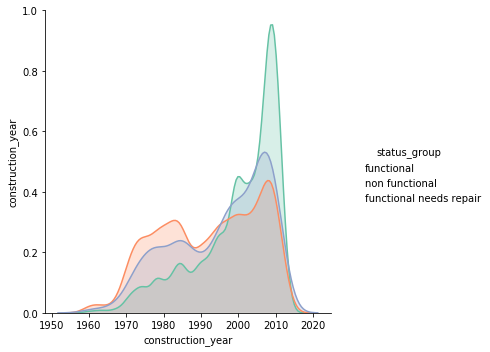

In [48]:
sns.pairplot(train_important_variables.loc[train_important_variables['construction_year'] != 0,:], height=5, vars=list(["construction_year"]), hue='status_group', 
             palette="Set2", diag_kind="kde")

#### Creating a season variable based on the month the record was taken information available - Feature Engineering
As the season in which the record was made may have an influence in the state of the dwell, a season variable will be created based on the month of the date_recorded.

In [49]:
def seasonsplit(x):
    #     short rain 10 11 12
    #     long rain 3 4 5 
        if int(x) in [11,12]:
            return 'short_rain'
        elif int(x) in [3,4,5]:
            return 'long_rain'
        elif int(x) in [1,2]:
            return 'short_dry'
        else:
            return 'long_dry'

df = train_important_variables.copy()        

df.date_recorded = pd.to_datetime(df.date_recorded)

df['record_month'] = df.date_recorded.apply(lambda x: str(x.month))

df['season'] = df.date_recorded.apply(lambda x:seasonsplit(x.month))
df.season = df.season.astype('object')
df.date_recorded = df.date_recorded.astype('object')

In [50]:
score_model_RF(label_encoder(df.copy().drop("record_month",axis = 1)))

Mean training score RF with CV: 0.8048, standard deviation: 0.0040 
RF Model score in holdout: 0.8034


The performance of the model increased, however in combination with the duration variable (implemented ahead) the overall performance of the model decreases and the standard deviation increases. Thus, this variable won't be implemented.

#### Creating a range variable, imputing construction_year "0" with median and substract the minimum year - Feature Engineering/Feature Transformation
As the construction year had around 40% of its values missing, they were imptuted with the median of all the other variables to then substract the minimum construction year. Then, a pattern was found between some year ranges, so the construction_year transformed were mapped into them. 

In [51]:
def cst_yr_split(x):
        if x < 1996:
            return 'range1'
        elif x >= 1996 and x < 2001:
            return 'range2'
        elif x >= 2001 and x < 2005:
            return 'range3'
        elif x >= 2005 and x < 2007:
            return 'range3'
        elif x >= 2007 and x < 2014:
            return 'range4'
        else:
            return 'range5'

df = train_important_variables.copy()        
        
cstyr = np.median(df[df.construction_year != 0].construction_year)
df.construction_year = df.construction_year.map(lambda x: cstyr if x==0 else x)
df['cst_yr_range'] = df.construction_year.map(lambda x: cst_yr_split(x))
df.construction_year = df.construction_year.map(lambda x: x-1960)

In [52]:
score_model_RF(label_encoder(df.copy()))

Mean training score RF with CV: 0.8030, standard deviation: 0.0036 
RF Model score in holdout: 0.8023


The performance of the model decreased and the standard deviation increased, thus, this approach won't be implemented.

#### Creating a new variable based on external information about earthquakes - Feature Engineering
While doing external research it was found that a strong earthquake happened in Tanzania in 2005. Thus, a new binary variable will be created based on this information.

In [53]:
df = train_important_variables.copy()

df.date_recorded = pd.to_datetime(df.date_recorded)
df['recorded_year'] = df.date_recorded.apply(lambda x: str(x.year))
df.date_recorded = df.date_recorded.astype("object")

df['before_2005'] = df.recorded_year.map(lambda x:'yes' if eval(x) < 2005 else 'no')
df.before_2005 = df.before_2005.astype('object')

In [54]:
score_model_RF(label_encoder(df.copy()))

Mean training score RF with CV: 0.8054, standard deviation: 0.0032 
RF Model score in holdout: 0.8035


The performance of the model increased, however in combination with the duration variable (implemented ahead) the overall performance of the model decreases and the standard deviation increases. Thus, this variable won't be implemented.

#### Creating a new variable based on the time information available - Feature Engineering
As the we have information about the construction year and the date that the register was taken (which have a wide range), we will try to create a "duration" variable which takes into consideration its interaction.

In [55]:
df_U2 = train_important_variables.copy()
df_U2.date_recorded = pd.to_datetime(df_U2.date_recorded)
df_U2['recorded_year'] = df_U2.date_recorded.map(lambda x: x.year)
df_U2['duration'] = df_U2.recorded_year.astype(int) - df_U2.construction_year
df_U2['duration'] = df_U2.duration.map(lambda x: x+10 if x < 0 else x)

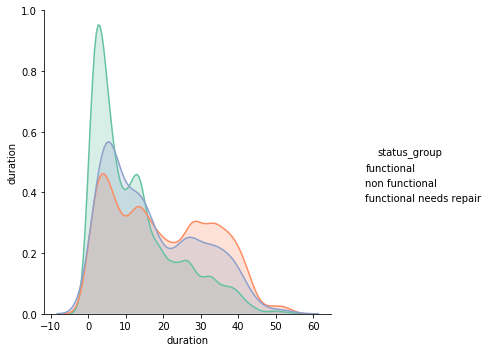

In [56]:
sns.pairplot(df_U2.loc[df_U2['duration'] < 2000,:], height=5, vars=list(["duration"]), hue='status_group', 
             palette="Set2", diag_kind="kde")

Visually it seems that this new variable has the same behavior as construction_year. Thus, we will evaluate its performance eliminating all the other variables that were used for its construction.

In [57]:
score_model_RF(label_encoder(df_U2.copy().drop(["date_recorded","construction_year","recorded_year"],axis=1)))

Mean training score RF with CV: 0.8052, standard deviation: 0.0055 
RF Model score in holdout: 0.8029


Its performance increased significantly but so the standard deviation increased. Thus, we will try some other approaches. The first one is to test with the created variable recorded_year as it makes more sense to be included instead of date_recorded which has too many unique values.

In [58]:
score_model_RF(label_encoder(df_U2.copy().drop(["date_recorded","duration"],axis=1)))

Mean training score RF with CV: 0.8037, standard deviation: 0.0049 
RF Model score in holdout: 0.8058


The performance of the model decreased and the standard deviation increased. Thus, the recorded year variable won't be used.

#### Creating a new variable based on the performance of each construction year - Feature Engineering
Rank the years of construction according to the status of the dwell.

In [59]:
df_U = train_important_variables.copy()

df_sub = df_U[['construction_year','status_group']]

df_sub = df_sub.set_index('construction_year',inplace=False)
df_sub.status_group = df_sub['status_group'].astype('category')
status_cat = pd.get_dummies(df_sub.status_group)
status_count = status_cat.groupby(level=0).sum()
status_count.columns = ['f','fr','nf']
status_count['total'] = status_count.f + status_count.fr + status_count.nf
status_count['performance'] = status_count.f / status_count.total

In [60]:
df_exp = train_important_variables.copy()

perf = list(range(0,10,1))
perf = [x/10 for x in perf]
perf[0] = -0.1
perf[-1] = 1.1

construction_year_performance = cut2cat(status_count,'performance',perf).reset_index()
construction_year_performance.rename(columns={'perInterval': 'per_construction_year'}, inplace=True)
df_exp = pd.merge(df_exp,construction_year_performance[["construction_year","per_construction_year"]], left_on = "construction_year", right_on = "construction_year",how = "left")


In [61]:
score_model_RF(label_encoder(df_exp.copy().drop("construction_year",axis=1)))

Mean training score RF with CV: 0.8040, standard deviation: 0.0039 
RF Model score in holdout: 0.8028


The model performance with the second approach is almost the same, thus, we will apply the first approach with the new feature "duration".

In [62]:
test_important_variables.date_recorded = pd.to_datetime(test_important_variables.date_recorded)
test_important_variables['recorded_year'] = test_important_variables.date_recorded.map(lambda x: x.year)
test_important_variables['duration'] = test_important_variables.recorded_year - test_important_variables.construction_year
test_important_variables['duration'] = test_important_variables.duration.map(lambda x: x+10 if x < 0 else x)

test_important_variables = test_important_variables.drop(["date_recorded","construction_year","recorded_year"],axis=1)

In [63]:
train_important_variables = df_U2.copy().drop(["date_recorded","construction_year","recorded_year"],axis=1)

## 4.3 Plotting the numerical variables 
Plot the numerical variables in order to understand their behavior.

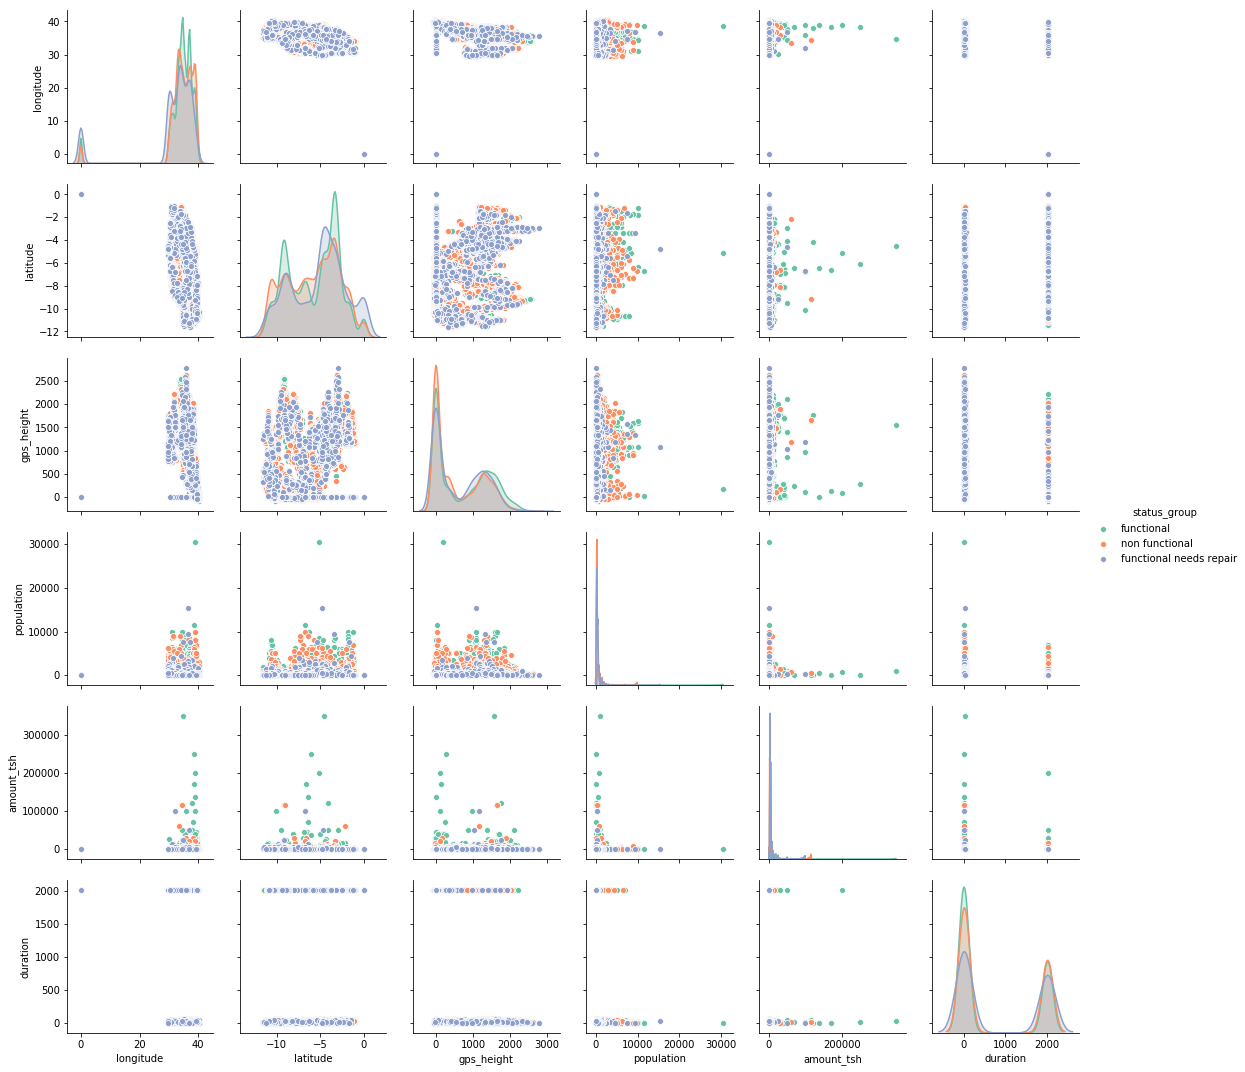

In [64]:
sns.pairplot(train_important_variables, height=2.5, vars=list(train_important_variables._get_numeric_data().columns), hue='status_group', 
             palette="Set2", diag_kind="kde")

From the graphs we can get the following insights

longitude, gps_height and construction_year: there are some "0" values which do not belong to the distribution of the variables. It is highly likely that "0" is the coding for missing values thus should be replaced if possible.

population and amount_ths: Are highly skeewed to the right and may have noise outliers. So they should be corrected.

### Evaluate the geographical data
As in the EDA the latitude, longitude and gps height variables seemed to have a lot of influence in the prediction. These variables will be evaluated deeply.

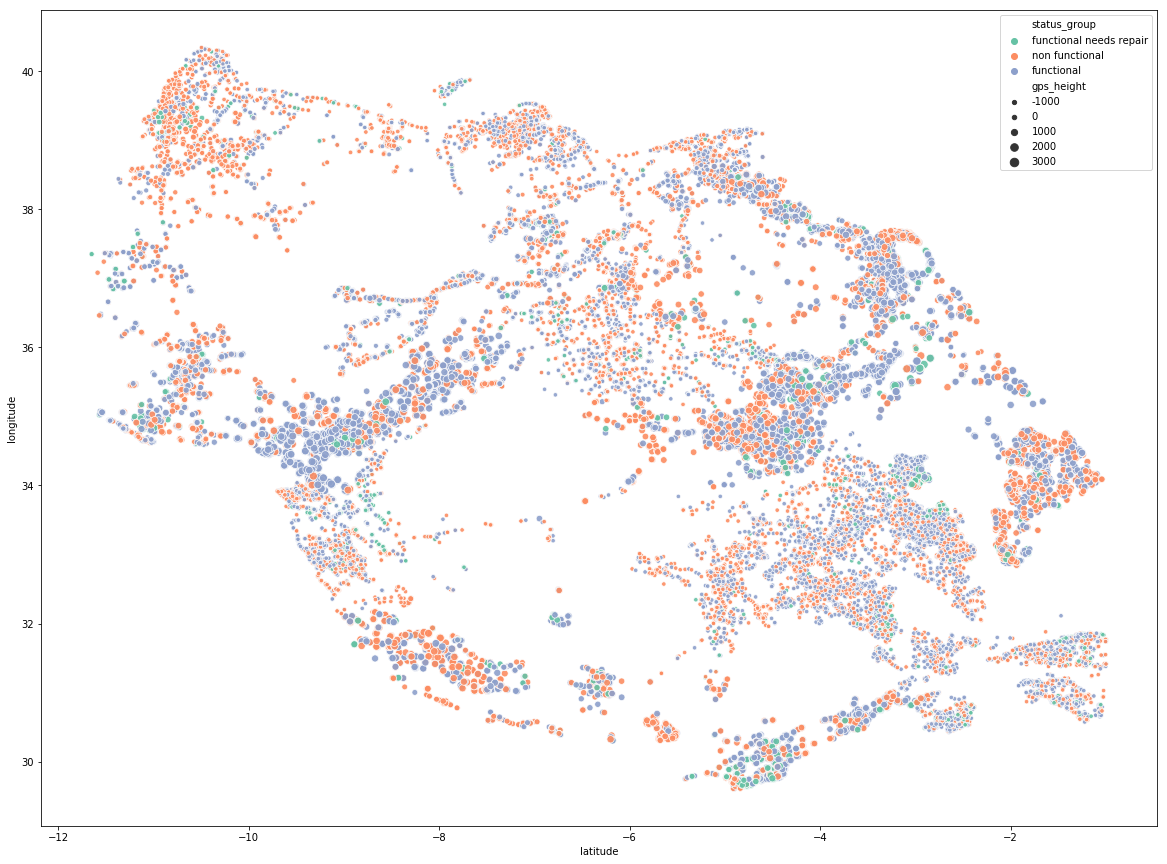

In [65]:
plt.subplots(figsize=(20,15))
sns.scatterplot(x = train_important_variables.loc[train_important_variables["longitude"] != 0,:].latitude, y = train_important_variables.loc[train_important_variables["longitude"] != 0,:].longitude, hue = train_important_variables.status_group, 
                size = train_important_variables.gps_height,
                alpha = 0.9,
                palette = "Set2",
                hue_order = ["functional needs repair","non functional","functional"])

### 4.3.1 longitude Variable

Plotting the original distribution of the longitude variable without the zeros.

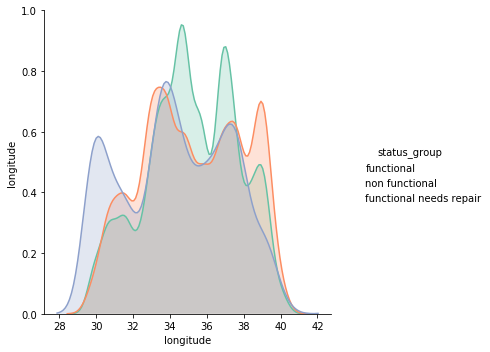

In [66]:
sns.pairplot(train_important_variables.loc[train_important_variables['longitude'] >0,:], height=5, vars=list(["longitude"]), hue='status_group', 
             palette="Set2", diag_kind="kde")

#### Correcting the longitude variable - Approach 1
Replacing the "0" values in the longitude variable by the median of the whole dataset.

In [67]:
df = train_important_variables.copy()

df["longitude"] = df["longitude"].replace(0, np.NaN)
df["longitude"] = df["longitude"].fillna(df["longitude"].median())

Plotting the distribution after using the first approach.

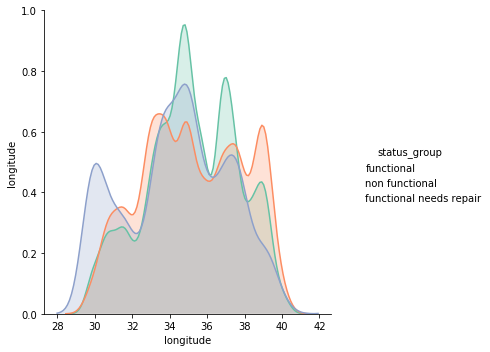

In [68]:
sns.pairplot(df.loc[df['longitude'] >0,:], height=5, vars=list(["longitude"]), hue='status_group', 
             palette="Set2", diag_kind="kde")

In [69]:
score_model_RF(label_encoder(df.copy()))

Mean training score RF with CV: 0.8054, standard deviation: 0.0038 
RF Model score in holdout: 0.8049


The performance increased some decimals and the variance decreased. Thus, this approach could be appropiate. However, we will try another one that may be more appropiate based on the geography.

#### Correcting the longitude variable - Approach 2
Replacing the "0" values in the longitude variable by the median according to the geographical information.

In [70]:
df = train_important_variables.copy()

# Add the geographical information to make a new dataframe with the median longitude of each lga (Local Government Authority)
df["lga"] = train_merged.lga

longitude_grouped = df.groupby("lga").median().reset_index()
#geo_location_grouped = df.groupby("geo_location").median().reset_index()

In [71]:
longitude_grouped[longitude_grouped["longitude"] == 0]

,lga,longitude,latitude,gps_height,population,amount_tsh,duration
5,Bariadi,0.0,-2.000000e-08,0.0,0.0,0.0,2013.0
15,Geita,0.0,-2.000000e-08,0.0,0.0,0.0,2011.0


In [72]:
# Imputing the latitude and longitude of Bariadi
longitude_grouped.loc[longitude_grouped['lga'] == "Bariadi","longitude"] = 33.9917
longitude_grouped.loc[longitude_grouped['lga'] == "Bariadi","latitude"] = -2.8070

# Imputing the latitude and longitude of Geita
longitude_grouped.loc[longitude_grouped['lga'] == "Geita","longitude"] = 32.2314
longitude_grouped.loc[longitude_grouped['lga'] == "Geita","latitude"] = -2.8850

In [73]:
df_left_join = pd.merge(df,longitude_grouped[["lga","longitude"]], left_on = "lga", right_on = "lga",how = "left")

In [74]:
df_left_join["longitude_x"] = df_left_join["longitude_x"].replace(0, np.NaN)
df_left_join.longitude_x.fillna(df_left_join.longitude_y,inplace=True)

In [75]:
df = df_left_join.drop(["longitude_y","lga"],axis = 1)
df.rename(columns={'longitude_x': 'longitude'}, inplace=True)
df.head(2)

,status_group,quantity,longitude,latitude,gps_height,extraction_type,waterpoint_type,population,management,source,...,source_class,public_meeting,water_quality,amount_tsh,management_group,geo_location,perInterval,per_scheme,per_funder,duration
0,functional,enough,34.938093,-9.856322,1390,gravity,communal standpipe,109,vwc,spring,...,groundwater,True,soft,6000.0,user-group,Ludewa:Mundindi,"(0.6, 0.7]","(0.8, 1.1]","(0.8, 1.1]",12
1,functional,insufficient,34.698766,-2.147466,1399,gravity,communal standpipe,280,wug,rainwater harvesting,...,surface,unknown,soft,0.0,user-group,Serengeti:Natta,"(0.8, 1.1]","(0.6, 0.7]","(0.8, 1.1]",3


Plotting the distribution after applying the second approach.

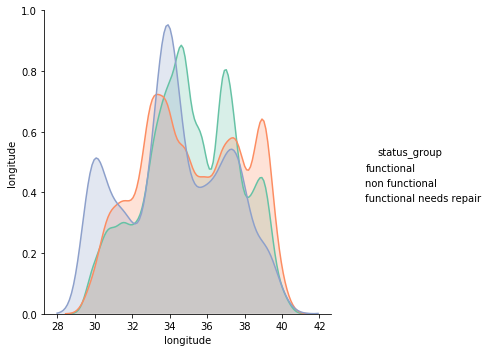

In [76]:
sns.pairplot(df, height=5, vars=list(["longitude"]), hue='status_group', 
             palette="Set2", diag_kind="kde")

In [77]:
score_model_RF(label_encoder(df.copy()))

Mean training score RF with CV: 0.8055, standard deviation: 0.0021 
RF Model score in holdout: 0.8019


The standard deviation of the model decreased significantly making the model more stable, and the performance also increased some decimals. Thus, this approach will be taken.

In [78]:
df_1 = test_important_variables.copy()

# Add the geographical information to make a new dataframe with the median longitude of each lga (Local Government Authority)
df_1["lga"] = train_merged.lga

df_1_left_join = pd.merge(df_1,longitude_grouped[["lga","longitude"]], left_on = "lga", right_on = "lga",how = "left")

df_1_left_join["longitude_x"] = df_1_left_join["longitude_x"].replace(0, np.NaN)
df_1_left_join.longitude_x.fillna(df_1_left_join.longitude_y,inplace=True)

df_1 = df_1_left_join.drop(["longitude_y","lga"],axis = 1)
df_1.rename(columns={'longitude_x': 'longitude'}, inplace=True)

test_important_variables = df_1.copy()

In [79]:
train_important_variables = df.copy()

In [80]:
score_model_RF(label_encoder(train_important_variables.copy()))

Mean training score RF with CV: 0.8055, standard deviation: 0.0021 
RF Model score in holdout: 0.8019


### 4.3.2 gps_height variable

Plotting the original distribution of the gps_height variable without the zeros.

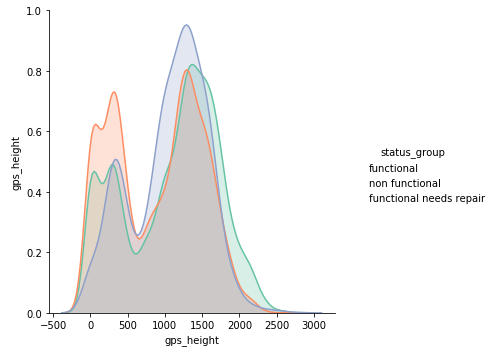

In [81]:
sns.pairplot(train_important_variables.loc[train_important_variables['gps_height'] != 0,:], height=5, vars=list(["gps_height"]), hue='status_group', 
             palette="Set2", diag_kind="kde")

#### Correcting the gps_height variable - Approach 1
Replacing the "0" values in the gps_height variable by the median of the whole dataset.

In [82]:
df = train_important_variables.copy()

df["gps_height"] = df["gps_height"].replace(0, np.NaN)
df["gps_height"] = df["gps_height"].fillna(df["gps_height"].median())

Plotting the distribution after applying the first approach.

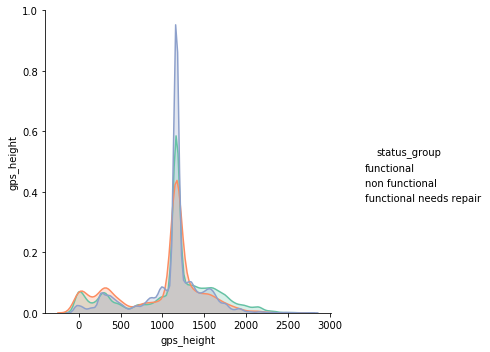

In [83]:
sns.pairplot(df, height=5, vars=list(["gps_height"]), hue='status_group', 
             palette="Set2", diag_kind="kde")

The distribution changed dramatically and we may be biasing the results by imputing the missing value with the median of the whole dataset.

In [84]:
score_model_RF(label_encoder(df.copy()))

Mean training score RF with CV: 0.8036, standard deviation: 0.0050 
RF Model score in holdout: 0.8039


The score decreased and the standard deviation increased several decimals, so a new approach have to be taken.

#### Correcting the gps_height variable - Approach 2
Replacing the "0" values in the gps_height variable by the median according to the geographical information.

In [85]:
longitude_grouped[longitude_grouped["gps_height"] == 0]

,lga,longitude,latitude,gps_height,population,amount_tsh,duration
4,Bahi,35.497937,-6.077469,0.0,0.0,0.0,2011.0
5,Bariadi,33.991700,-2.807000,0.0,0.0,0.0,2013.0
6,Biharamulo,31.342989,-2.800315,0.0,0.0,0.0,2011.0
7,Bukoba Rural,31.606750,-1.443013,0.0,0.0,0.0,2011.0
8,Bukoba Urban,31.804602,-1.315174,0.0,0.0,0.0,2011.0
9,Bukombe,32.049816,-3.380587,0.0,0.0,0.0,2012.0
11,Chamwino,35.999380,-6.255412,0.0,0.0,0.0,2011.0
12,Chato,31.715839,-2.633555,0.0,0.0,0.0,2011.0
13,Chunya,33.158536,-8.520392,0.0,0.0,0.0,2011.0
14,Dodoma Urban,35.858492,-6.128759,0.0,0.0,0.0,2011.0


In [86]:
# Replacing the gps_height values of the cities lga without information using a external dataset.

longitude_grouped.loc[longitude_grouped['lga'] == "Bahi","gps_height"] = 839
longitude_grouped.loc[longitude_grouped['lga'] == "Bariadi","gps_height"] = 1297
longitude_grouped.loc[longitude_grouped['lga'] == "Biharamulo","gps_height"] = 1441
longitude_grouped.loc[longitude_grouped['lga'] == "Bukoba Rural","gps_height"] = 1158
longitude_grouped.loc[longitude_grouped['lga'] == "Bukoba Urban","gps_height"] = 1158
longitude_grouped.loc[longitude_grouped['lga'] == "Bukombe","gps_height"] = 1175
longitude_grouped.loc[longitude_grouped['lga'] == "Chamwino","gps_height"] = 1009
longitude_grouped.loc[longitude_grouped['lga'] == "Chato","gps_height"] = 1149
longitude_grouped.loc[longitude_grouped['lga'] == "Chunya","gps_height"] = 1547
longitude_grouped.loc[longitude_grouped['lga'] == "Dodoma Urban","gps_height"] = 1119
longitude_grouped.loc[longitude_grouped['lga'] == "Geita","gps_height"] = 1240
longitude_grouped.loc[longitude_grouped['lga'] == "Igunga","gps_height"] = 1194
longitude_grouped.loc[longitude_grouped['lga'] == "Ileje","gps_height"] = 2078
longitude_grouped.loc[longitude_grouped['lga'] == "Ilemela","gps_height"] = 1158
longitude_grouped.loc[longitude_grouped['lga'] == "Kahama","gps_height"] = 1264
longitude_grouped.loc[longitude_grouped['lga'] == "Karagwe","gps_height"] = 1403
longitude_grouped.loc[longitude_grouped['lga'] == "Kilindi","gps_height"] = 800
longitude_grouped.loc[longitude_grouped['lga'] == "Kishapu","gps_height"] = 1173
longitude_grouped.loc[longitude_grouped['lga'] == "Kondoa","gps_height"] = 1372
longitude_grouped.loc[longitude_grouped['lga'] == "Kongwa","gps_height"] = 1014
longitude_grouped.loc[longitude_grouped['lga'] == "Kwimba","gps_height"] = 1219
longitude_grouped.loc[longitude_grouped['lga'] == "Kyela","gps_height"] = 488
longitude_grouped.loc[longitude_grouped['lga'] == "Magu","gps_height"] = 1149
longitude_grouped.loc[longitude_grouped['lga'] == "Maswa","gps_height"] = 1333
longitude_grouped.loc[longitude_grouped['lga'] == "Mbarali","gps_height"] = 1316
longitude_grouped.loc[longitude_grouped['lga'] == "Mbeya Rural","gps_height"] = 1711
longitude_grouped.loc[longitude_grouped['lga'] == "Mbozi","gps_height"] = 1409
longitude_grouped.loc[longitude_grouped['lga'] == "Meatu","gps_height"] = 1459
longitude_grouped.loc[longitude_grouped['lga'] == "Misenyi","gps_height"] = 1161
longitude_grouped.loc[longitude_grouped['lga'] == "Missungwi","gps_height"] = 1188
longitude_grouped.loc[longitude_grouped['lga'] == "Mkinga","gps_height"] = 1191
longitude_grouped.loc[longitude_grouped['lga'] == "Mpwapwa","gps_height"] = 1011
longitude_grouped.loc[longitude_grouped['lga'] == "Muleba","gps_height"] = 1275
longitude_grouped.loc[longitude_grouped['lga'] == "Ngara","gps_height"] = 1775
longitude_grouped.loc[longitude_grouped['lga'] == "Nyamagana","gps_height"] = 1134
longitude_grouped.loc[longitude_grouped['lga'] == "Nzega","gps_height"] = 1238
longitude_grouped.loc[longitude_grouped['lga'] == "Rungwe","gps_height"] = 1580
longitude_grouped.loc[longitude_grouped['lga'] == "Sengerema","gps_height"] = 1225
longitude_grouped.loc[longitude_grouped['lga'] == "Shinyanga Rural","gps_height"] = 1233
longitude_grouped.loc[longitude_grouped['lga'] == "Shinyanga Urban","gps_height"] = 1168
longitude_grouped.loc[longitude_grouped['lga'] == "Sikonge","gps_height"] = 1158
longitude_grouped.loc[longitude_grouped['lga'] == "Tabora Urban","gps_height"] = 1240
longitude_grouped.loc[longitude_grouped['lga'] == "Urambo","gps_height"] = 1119
longitude_grouped.loc[longitude_grouped['lga'] == "Uyui","gps_height"] = 1213

In [87]:
# Initialize the df again
df = train_important_variables.copy()
df["lga"] = train_merged.lga

df_left_join = pd.merge(df,longitude_grouped[["lga","gps_height"]], left_on = "lga", right_on = "lga",how = "left")

In [88]:
df_left_join["gps_height_x"] = df_left_join["gps_height_x"].replace(0, np.NaN)
df_left_join.gps_height_x.fillna(df_left_join.gps_height_y,inplace=True)

In [89]:
df = df_left_join.drop(["gps_height_y","lga"],axis = 1)
df.rename(columns={'gps_height_x': 'gps_height'}, inplace=True)
df.head(2)

,status_group,quantity,longitude,latitude,gps_height,extraction_type,waterpoint_type,population,management,source,...,source_class,public_meeting,water_quality,amount_tsh,management_group,geo_location,perInterval,per_scheme,per_funder,duration
0,functional,enough,34.938093,-9.856322,1390.0,gravity,communal standpipe,109,vwc,spring,...,groundwater,True,soft,6000.0,user-group,Ludewa:Mundindi,"(0.6, 0.7]","(0.8, 1.1]","(0.8, 1.1]",12
1,functional,insufficient,34.698766,-2.147466,1399.0,gravity,communal standpipe,280,wug,rainwater harvesting,...,surface,unknown,soft,0.0,user-group,Serengeti:Natta,"(0.8, 1.1]","(0.6, 0.7]","(0.8, 1.1]",3


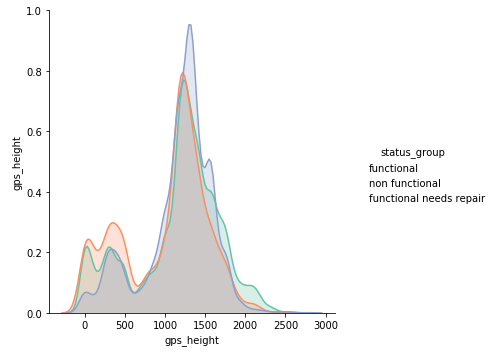

In [90]:
sns.pairplot(df, height=5, vars=list(["gps_height"]), hue='status_group', 
             palette="Set2", diag_kind="kde")

In [91]:
score_model_RF(label_encoder(df.copy()))

Mean training score RF with CV: 0.8029, standard deviation: 0.0036 
RF Model score in holdout: 0.8027


The second approach decreased both the performance and the standard deviation. Thus, no transformation will be applied to the gps_height variable.

### 4.3.3 Population and amount_tsh skewness

#### Analize deeper the distribution of the population and amount_tsh variable

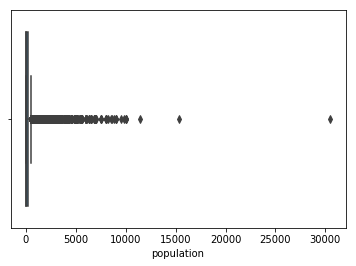

In [92]:
sns.boxplot(x=train_merged.loc[:,"population"])

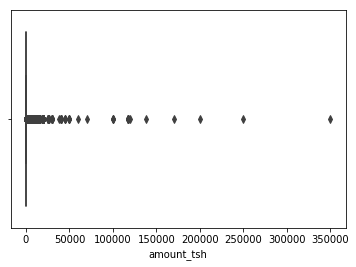

In [93]:
sns.boxplot(x=train_merged.loc[:,"amount_tsh"])

#### Evaluate the skewness of the numerical variables
Determine the skewness of the train dataset.

In [94]:
feature_skew = train_important_variables[train_important_variables._get_numeric_data().columns].apply(
        lambda x: skew(x))

skews = pd.DataFrame({'skew':feature_skew})
skews

,skew
longitude,-0.086053
latitude,-0.152033
gps_height,0.462390
population,12.660394
amount_tsh,57.806340
duration,0.634911


Determine the skewness of the test set to see if it has the same behavior and the correction can be generalized.

In [95]:
feature_skew_test = test_important_variables[test_important_variables._get_numeric_data().columns].apply(
        lambda x: skew(x))

skews_test = pd.DataFrame({'skew':feature_skew_test})
skews_test

,skew
id,-0.010583
longitude,-0.134075
latitude,-0.156223
gps_height,0.497043
population,8.216318
amount_tsh,43.853431
duration,0.609321


As it can be seen both visually and in the skewnes analysis, the variables population and amount_tsh are extremely skewed (both for the train and test set), thus we will first correct the skewness.

#### Correct the skewed numerical variables

In [96]:
df = train_important_variables.copy()

skewed_numeric_dtypes = ['population', 'amount_tsh']

for i in skewed_numeric_dtypes:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i]+1))
        
feature_skew = df[df._get_numeric_data().columns].apply(
        lambda x: skew(x))

skews = pd.DataFrame({'skew':feature_skew})
skews

,skew
longitude,-0.086053
latitude,-0.152033
gps_height,0.462390
population,0.577864
amount_tsh,1.302736
duration,0.634911


In [97]:
score_model_RF(label_encoder(df.copy()))

Mean training score RF with CV: 0.8054, standard deviation: 0.0023 
RF Model score in holdout: 0.8022


The performance of the model decreased a bit and the standard deviation too. Thus, the skewness won't be corrected.

### 4.3.4 population variable

Plotting the original distribution of the population variable without the zeros.

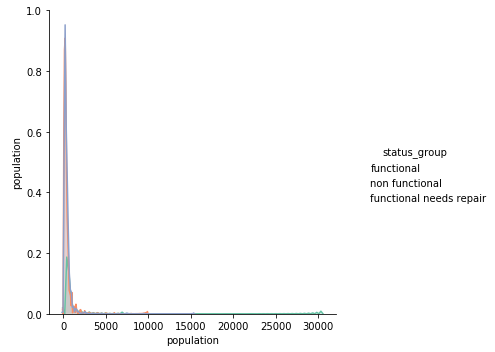

In [98]:
sns.pairplot(train_important_variables.loc[train_important_variables['population'] != 0,:], height=5, vars=list(["population"]), hue='status_group', 
             palette="Set2", diag_kind="kde")

#### Correcting the population variable - Approach 1
Replacing the "0" values in the population variable by the median of the whole dataset.

In [99]:
df = train_important_variables.copy()

df["population"] = df["population"].replace(0, np.NaN)
df["population"] = df["population"].fillna(df["population"].median())

Plotting the distribution after applying the first approach.

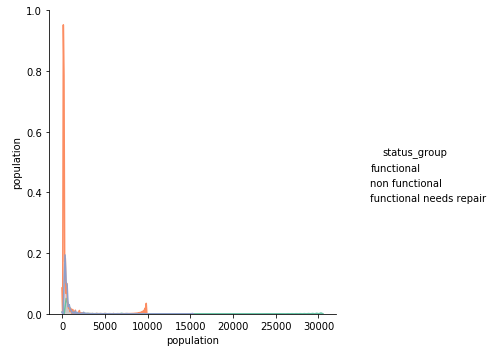

In [100]:
sns.pairplot(df, height=5, vars=list(["population"]), hue='status_group', 
             palette="Set2", diag_kind="kde")

The distribution changed dramatically and we may be biasing the results by imputing the missing value with the median of the whole dataset.

In [101]:
score_model_RF(label_encoder(df.copy()))

Mean training score RF with CV: 0.8047, standard deviation: 0.0032 
RF Model score in holdout: 0.8037


The score decreased significantly and the standard deviation increased, thus, another approach should be tested.

#### Correcting the population variable - Approach 2
Creating a new variable that group the levels which does not have information about the population.

In [102]:
df = train_important_variables.copy()

geo_location_grouped = df.groupby("geo_location").median().reset_index()
locations_no_info = list(geo_location_grouped[geo_location_grouped["population"] == 0]["geo_location"])

In [103]:
len(locations_no_info)

857

In [104]:
len(locations_no_info)/len(geo_location_grouped)

0.3911455956184391

In [105]:
df['grouped_location'] = np.nan

df['grouped_location'] = ['others' if df['geo_location'][i] in locations_no_info else df['geo_location'][i] for i in range(0,len(df))]

In [106]:
df.head(1)

,status_group,quantity,longitude,latitude,gps_height,extraction_type,waterpoint_type,population,management,source,...,public_meeting,water_quality,amount_tsh,management_group,geo_location,perInterval,per_scheme,per_funder,duration,grouped_location
0,functional,enough,34.938093,-9.856322,1390,gravity,communal standpipe,109,vwc,spring,...,True,soft,6000.0,user-group,Ludewa:Mundindi,"(0.6, 0.7]","(0.8, 1.1]","(0.8, 1.1]",12,Ludewa:Mundindi


In [107]:
score_model_RF(label_encoder(df.copy().drop(["geo_location"],axis = 1)))

Mean training score RF with CV: 0.8037, standard deviation: 0.0042 
RF Model score in holdout: 0.8006


The performance of the model decreased and the standard deviation increased, that is mainly because almost 40% of the location information has no data about population. Therefore, we can try two approaches, model without this variable as it has too many missing values or bin it and treat it as categorical.

#### Correcting the population variable - Approach 3
Modeling without the population variable.

In [108]:
df = train_important_variables.copy()

score_model_RF(label_encoder(df.copy().drop(["population"],axis = 1)))

Mean training score RF with CV: 0.8016, standard deviation: 0.0038 
RF Model score in holdout: 0.7971


The performance of the model decreased significantly and the standard deviation increased, thus, the variable cannot be removed. 

#### Correcting the population variable - Approach 4
Bin the population variable based on percentiles and then work it as categorical.

In [109]:
df = train_important_variables.copy()

avghr_bins = np.unique(np.percentile(df.population,[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).tolist())

avghr_bins[0] = -0.000001

df['population_bin'] = pd.cut(df.population,avghr_bins).astype('object')
df.drop('population', inplace=True, axis=1)

df.head(2)

,status_group,quantity,longitude,latitude,gps_height,extraction_type,waterpoint_type,management,source,payment,...,public_meeting,water_quality,amount_tsh,management_group,geo_location,perInterval,per_scheme,per_funder,duration,population_bin
0,functional,enough,34.938093,-9.856322,1390,gravity,communal standpipe,vwc,spring,pay annually,...,True,soft,6000.0,user-group,Ludewa:Mundindi,"(0.6, 0.7]","(0.8, 1.1]","(0.8, 1.1]",12,"(90.0, 160.0]"
1,functional,insufficient,34.698766,-2.147466,1399,gravity,communal standpipe,wug,rainwater harvesting,never pay,...,unknown,soft,0.0,user-group,Serengeti:Natta,"(0.8, 1.1]","(0.6, 0.7]","(0.8, 1.1]",3,"(260.0, 453.0]"


In [110]:
score_model_RF(label_encoder(df.copy()))

Mean training score RF with CV: 0.8056, standard deviation: 0.0050 
RF Model score in holdout: 0.8047


The performance of the model increases, nevertheless the standard deviation increased significantly. Thus, another approach should be tested.

#### Correcting the population variable - Approach 5
Bin the population based on rankings

In [111]:
df_U = train_important_variables.copy()

df_sub = df_U[['population','status_group']]

df_sub = df_sub.set_index('population',inplace=False)
df_sub.status_group = df_sub['status_group'].astype('category')
status_cat = pd.get_dummies(df_sub.status_group)
status_count = status_cat.groupby(level=0).sum()
status_count.columns = ['f','fr','nf']
status_count['total'] = status_count.f + status_count.fr + status_count.nf
status_count['performance'] = status_count.f / status_count.total

In [112]:
df_exp = train_important_variables.copy()

perf = list(range(0,10,1))
perf = [x/10 for x in perf]
perf[0] = -0.1
perf[-1] = 1.1

population_performance = cut2cat(status_count,'performance',perf).reset_index()
population_performance.rename(columns={'perInterval': 'per_population'}, inplace=True)
df_exp = pd.merge(df_exp,population_performance[["population","per_population"]], left_on = "population", right_on = "population",how = "left")


In [113]:
score_model_RF(label_encoder(df_exp.copy().drop("population",axis=1)))

Mean training score RF with CV: 0.8053, standard deviation: 0.0042 
RF Model score in holdout: 0.8037


Even though this was the approach with the least impact when imputing the missing values of population, the performance score decreased and the standard deviation increased. Thus, the conclusion is that as there are so many missing values that there is no imputing approach that can help us to improve the model and it is better to leave the variable as it is.

### 4.3.5 amount_tsh

Plotting the original distribution of the amount_tsh variable without the zeros once skewness has been corrected.

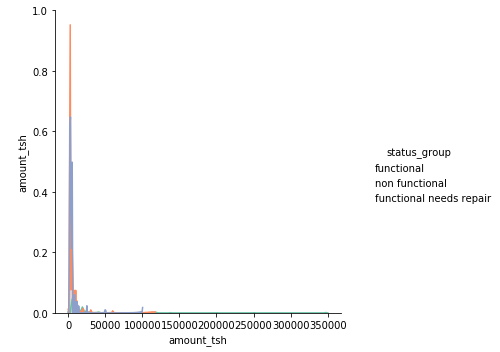

In [114]:
sns.pairplot(train_important_variables.loc[train_important_variables['amount_tsh'] != 0,:], height=5, vars=list(["amount_tsh"]), hue='status_group', 
             palette="Set2", diag_kind="kde")

#### Correcting the amount_tsh variable
As amount_tsh has a similar performance to population we will apply the technique which had the least impact in the performance of the model to see if it has positive effect on this variable.

In [115]:
df = train_important_variables.copy()

df["amount_tsh"] = df["amount_tsh"].replace(0, np.NaN)
df["amount_tsh"] = df["amount_tsh"].fillna(df["amount_tsh"].median())

In [116]:
score_model_RF(label_encoder(df.copy()))

Mean training score RF with CV: 0.8038, standard deviation: 0.0041 
RF Model score in holdout: 0.8017


The decreasing in the performance and standard deviation of the model is significant, thus, we won't apply this transformation to the training data, nor the testing data. The conclusion is that as there are so many missing values there is no imputing approach that can help us to improve the model.

# 5. Production Models
After all the transformations and feature engineering functions have been tested and accepted according to their influence in the model performance. The next step is to put the transformed datasets into production.

### Label Encoding
The first transformation is to encode the categorical variables so that the production models can work.

In [117]:
train_encoded = label_encoder(train_important_variables.copy())
test_encoded = label_encoder(test_important_variables.copy())
#train_encoded.head(1)
#test_encoded.head(1)

## 5.1 Production Model No.1 - Random Forest (with optimized hyperparameters)
For the random forest model the hyperparamenters were optimized with random search, nevertheless it the final model just the best ones were maintained due to the required computational power.

### 5.1.1 Cross Validation

In [118]:
data_transformed = train_encoded.copy()
test_transformed = test_encoded.copy().loc[:, test_encoded.columns != 'id']
    
# Subseting the training data into the dependent and independent variables dataframe
X = data_transformed.loc[:, data_transformed.columns != 'status_group']
y = data_transformed.loc[:, 'status_group']
    
# Creating a training and testing subset to evaluate the performance of the model
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=4852347)
        
# Defining the Random Forest model that will be used in production
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
        max_depth=None, max_features='auto', max_leaf_nodes=None,
        min_impurity_decrease=0.0, min_impurity_split=None,
        min_samples_leaf=1, min_samples_split=2,
        min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
        oob_score=False, random_state=4852347, verbose=0,
        warm_start=False)    
        
# Cross Validation of the Scores to stabilize variance and don't eliminate functions with only 
# one run of the model
scores = cross_val_score(clf, 
                        X_train, y_train, 
                        scoring='accuracy', cv=10)
    
print('Mean training score RF with CV: {:.4f}, standard deviation: {:.4f} '.format(np.mean(scores), np.std(scores)), 
              end='')
    
clf.fit(X_train, y_train)
print('\nRF Model score in holdout: {:.4f}'.format(clf.score(X_test, y_test)))

Mean training score RF with CV: 0.8150, standard deviation: 0.0021 
RF Model score in holdout: 0.8119


### 5.1.2 Prediction 

In [119]:
# Fitting the model over the whole training set
clf.fit(X, y)
# Creating the final dataframe for the predictions recovering the "id" field
prediction_RF = pd.concat([test_encoded.copy().loc[:, "id"], test_transformed.copy()], axis=1)
# Making the prediction and creating the new variable in the final dataframe 
prediction_RF["status_group_num_RF"]= clf.predict(test_transformed.copy())

# Creating the final dataframe for the stack model recovering the "id" field
stack_RF = pd.concat([train_labels.copy().loc[:, "id"], data_transformed.copy()], axis=1)
# Making the prediction and creating the new variable in the final dataframe for the stacked model 
stack_RF["status_group_num_RF"]= clf.predict(X.copy())
    
# Creating the dictionary with the original values without label encoding
lkup = { 0: "functional", 2 : "non functional", 1 : "functional needs repair"}
# Applying the map function to create a new column with the final prediction in the appropriate format
prediction_RF["status_group"] = prediction_RF["status_group_num_RF"].map(lkup).astype("category")
    
# Creating the .csv file with the predicted values in the format asked in the competition
prediction_RF.loc[:,["id","status_group"]].to_csv('../Data/random_forest.csv', index=False)
    
stack_RF_final = stack_RF.copy().loc[:,["id","status_group_num_RF"]]

## 5.2 Production model No.2 - XGBoost (with randomized grid search hyperparameters)

### 5.2.1 Cross Validation

In [120]:
# Creating a copy of the training and testing data that is going to be used in the model
data_transformed = train_encoded.copy()
test_transformed = test_encoded.copy().loc[:, test_encoded.columns != 'id']

# Subseting the training data into the dependent and independent variables dataframe
X = data_transformed.loc[:, data_transformed.columns != 'status_group']
y = data_transformed.loc[:, 'status_group']
        
# Creating the DMatrix object used by XGBoost
data_dmatrix = xgb.DMatrix(data = X, label = y)

# Defining the final parameters obtained after doing the Random Grid Search
gbm_param_grid = {
    'learning_rate': [0.9],
    'max_depth': [15],  # the maximum depth of each tree
    'subsample': [1],
    'colsample_bytree': [0.6],
    'eta': [0.05],  # the training step for each iteration
    'num_class': [4],   
    'n_estimators': [10]
    }
   
# Defining the XGB classifier for a multiclass classification problem
gbm = xgb.XGBClassifier(objective = "multi:softprob")
    
#  Running the Random Grid Search with CV to get the best scores
randomized_error = RandomizedSearchCV(estimator=gbm, 
                                      param_distributions=gbm_param_grid, n_iter=25,
                                      cv=5, verbose=1)
# The randomized grid search was run one-by-one parameter and then the best values were replaced due to the
# computational power and time needed to do everything at once
    
# Fitting the model based on the results of the Random Grid Search
XGB_model = randomized_error.fit(X,y)

print('Best production estimator Accuracy score: {:.4f} with a standard deviation: {:.4f}'.format(XGB_model.best_score_,XGB_model.cv_results_['std_test_score'][0]))  

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.8s finished


Best production estimator Accuracy score: 0.8136 with a standard deviation: 0.0032


### 5.2.2 Prediction

In [121]:
# Creating the final dataframe for the predictions recovering the "id" field
prediction_XGB = pd.concat([test_encoded.copy().loc[:, "id"], test_transformed.copy()], axis=1)
# Making the prediction and creating the new variable in the final dataframe 
prediction_XGB["status_group_num_XGB"]= XGB_model.predict(test_transformed.copy())

# Creating the final dataframe for the stack model recovering the "id" field
stack_XGB = pd.concat([train_labels.copy().loc[:, "id"], data_transformed.copy()], axis=1)
# Making the prediction and creating the new variable in the final dataframe for the stacked model 
stack_XGB["status_group_num_XGB"]= XGB_model.predict(X.copy())

# Creating the dictionary with the original values without label encoding
lkup = { 0: "functional", 2 : "non functional", 1 : "functional needs repair"}  
# Applying the map function to create a new column with the final prediction in the appropriate format
prediction_XGB["status_group"] = prediction_XGB["status_group_num_XGB"].map(lkup).astype("category")
    
# Creating the .csv file with the predicted values in the format asked in the competition
prediction_XGB.loc[:,["id","status_group"]].to_csv('../Data/XGBoost.csv', index=False)
    
# Returning the predicted dataframe and the best score of the model over the testing dataframe from the 
# subset of the training dataframe
stack_XGB_final = stack_XGB.copy().loc[:,["id","status_group_num_XGB"]]

# 6. Model stacking

## 6.1 Joining models results


### 6.1.1 Training Data
Joining the results of both models with the actual values of the training set to create a training dataset for the stacked model.

In [122]:
# Creating a set with the results from the Random Forest Model, the XGBoost model and the train labels.
dfs = [stack_RF_final.copy(), stack_XGB_final.copy(), pd.concat([train_labels.copy().loc[:, "id"], data_transformed.copy()], axis=1)]
# Merging all the the dataframes of the dfs set
stacked_df = label_encoder(reduce(lambda left,right: pd.merge(left,right,on='id'), dfs)).drop("id",axis = 1)

In [123]:
stacked_df.head()

,status_group_num_RF,status_group_num_XGB,status_group,quantity,longitude,latitude,gps_height,extraction_type,waterpoint_type,population,...,source_class,public_meeting,water_quality,amount_tsh,management_group,geo_location,perInterval,per_scheme,per_funder,duration
0,0,0,0,1,34.938093,-9.856322,1390,3,1,109,...,0,1,6,6000.0,4,908,6,8,8,12
1,0,0,0,2,34.698766,-2.147466,1399,3,1,280,...,1,2,6,0.0,4,1858,8,6,8,3
2,0,0,0,1,37.460664,-3.821329,686,3,2,250,...,1,1,6,25.0,4,1909,6,8,8,4
3,2,2,2,0,38.486161,-11.155298,263,14,2,58,...,0,1,6,0.0,4,1573,5,4,5,27
4,0,0,0,3,31.130847,-1.825359,0,3,1,0,...,1,1,6,0.0,1,492,5,4,8,2011


### 6.1.2 Testing Data
Joining the results of both models with the predicted values of the test set to make the predictions.

In [124]:
# Creating a set with the results from the Random Forest Model, the XGBoost model and the test labels.
dfs = [prediction_RF.loc[:,["id","status_group_num_RF"]].copy(), prediction_XGB.loc[:,["id","status_group_num_XGB"]].copy(), test_encoded.copy()]
# Merging all the the dataframes of the dfs set
predicted_df = reduce(lambda left,right: pd.merge(left,right,on='id'), dfs)


In [125]:
predicted_df.head()

,id,status_group_num_RF,status_group_num_XGB,quantity,longitude,latitude,gps_height,extraction_type,waterpoint_type,population,...,source_class,public_meeting,water_quality,amount_tsh,management_group,geo_location,perInterval,per_scheme,per_funder,duration
0,50785,0,0,3,35.290799,-4.059696,1996,9,6,321,...,1,1,6,0.0,2,1056,7,5,8,1
1,51630,0,0,2,36.656709,-3.309214,1569,3,1,300,...,0,1,6,0.0,4,3,5,4,4,13
2,17168,2,2,2,34.767863,-5.004344,1567,9,6,500,...,1,1,6,0.0,4,1810,5,1,5,3
3,45559,2,2,0,38.058046,-9.418672,267,9,6,250,...,0,2,6,0.0,4,823,0,4,0,26
4,49871,0,0,1,35.006123,-10.950412,1260,3,1,60,...,0,2,6,500.0,4,1018,8,8,8,13


Creating a transform dataset without the "id" column so it can be used for the prediction.

In [126]:
predicted_df_transformed = label_encoder(predicted_df.drop("id",axis = 1))

## 6.2 Stacked Model
Creating the model that will make the prediction from the results of the previous models.

### 6.2.1 Cross Validation
Evaluating the model performance using cross validation to determine if it is overfitting.

In [127]:
# Dividing the dataset in dependent and independent variable
X = stacked_df.loc[:, stacked_df.columns != 'status_group']
y = stacked_df.loc[:, 'status_group']

# Creating a training and testing subset to evaluate the performance of the model
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.20, 
                                                        random_state=1324)

# Defining the Random Forest model that will be used in production
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
        max_depth=None, max_features='auto', max_leaf_nodes=None,
        min_impurity_decrease=0.0, min_impurity_split=None,
        min_samples_leaf=1, min_samples_split=2,
        min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
        oob_score=False, random_state=None, verbose=0,
        warm_start=False)    
        
# Cross Validation of the Scores to stabilize variance and don't eliminate functions with only 
# one run of the model
scores = cross_val_score(rfc, 
                        X_train, y_train, 
                        scoring='accuracy', cv=10)
    
print('Mean training score RF with CV: {:.4f}, standard deviation: {:.4f} '.format(np.mean(scores), np.std(scores)), 
              end='')
    
rfc.fit(X_train, y_train)
print('\nRF Model score in holdout: {:.4f}'.format(rfc.score(X_test, y_test)))

Mean training score RF with CV: 0.9975, standard deviation: 0.0007 
RF Model score in holdout: 0.9978


### 6.2.2 Prediction
Making the prediction and transforming the data into the format asked in the competition.

In [128]:
predicted_df_transformed.head(2)

,status_group_num_RF,status_group_num_XGB,quantity,longitude,latitude,gps_height,extraction_type,waterpoint_type,population,management,...,source_class,public_meeting,water_quality,amount_tsh,management_group,geo_location,perInterval,per_scheme,per_funder,duration
0,0,0,3,35.290799,-4.059696,1996,9,6,321,3,...,1,1,6,0.0,2,1056,7,5,8,1
1,0,0,2,36.656709,-3.309214,1569,3,1,300,7,...,0,1,6,0.0,4,3,5,4,4,13


In [129]:
# Fitting the model over the whole training set
rfc.fit(X, y)
    
# Creating the final dataframe for the predictions recovering the "id" field
prediction_stacked = test_encoded.copy()
    
# Making the prediction and creating the new variable in the final dataframe 
prediction_stacked["status_group_num"]= rfc.predict(predicted_df_transformed.copy())
   
# Creating the dictionary with the original values without label encoding
lkup = { 0: "functional", 2 : "non functional", 1 : "functional needs repair"}
    
# Applying the map function to create a new column with the final prediction in the appropriate format
prediction_stacked["status_group"] = prediction_stacked["status_group_num"].map(lkup).astype("category")
    
# Dropping the numerical prediction as it is not needed anymore
prediction_stacked.drop('status_group_num', inplace=True, axis=1)
    
# Creating the .csv file with the predicted values in the format asked in the competition
prediction_stacked.loc[:,["id","status_group"]].to_csv('../Data/stacked.csv', index=False)